# Project: Investigate a Dataset (No-Show Medical Appointments in Brazil)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This report will look at how various health and timing related variables affect the probability of patients missing medical appointments in Brazil. The data set provides information on several health conditions as well as basic patient information such as gender and age.  Further, there is some timing data included in the data set such as when an appointment was scheduled and the day of the appointment, as well as whether or not a text message reminder was received or not. I would like to see if there is a correlation between the gap between the scheduled day/appointment day and the likelihood of missing the appointment. The question is: which, if any, of these factors indicate whether or not a patient will show up for an appointment?

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> Check for missing entries, duplicates, and outliers in the data.

### General Properties

In [2]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


>Drop irrelevant columns:

In [3]:
df.drop(['AppointmentID','PatientId','Neighbourhood'], axis = 1, inplace = True)
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,0,0,No


>Clean column titles and fix typos:

In [4]:
df.rename(columns = { 'Gender':'gender', 'ScheduledDay':'scheduled_day', 'AppointmentDay':'appointment_day', 'Age':'age','Scholarship':'scholarship','Hipertension':'hypertension','Diabetes':'diabetes','Alcoholism':'alcoholism','Handcap':'handicap','SMS_received':'sms_received', 'No-show':'no_show'}, inplace=True)
df.head()

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,0,0,No


> Check for missing entries:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 11 columns):
gender             110527 non-null object
scheduled_day      110527 non-null object
appointment_day    110527 non-null object
age                110527 non-null int64
scholarship        110527 non-null int64
hypertension       110527 non-null int64
diabetes           110527 non-null int64
alcoholism         110527 non-null int64
handicap           110527 non-null int64
sms_received       110527 non-null int64
no_show            110527 non-null object
dtypes: int64(7), object(4)
memory usage: 9.3+ MB


>Nothing appears to be missing and the data types are okay for now.

>Check for and remove duplicate rows:

In [6]:
df.duplicated().sum()

722

In [7]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

>Check for outliers:

In [8]:
for x in df.columns:
    print(df[x].unique())

['F' 'M']
['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z' ...
 '2016-04-27T16:03:52Z' '2016-04-27T15:09:23Z' '2016-04-27T13:30:56Z']
['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-25T00:00:00Z'
 '2016-05-11T00:00:00Z' '2016-05-18T00:00:00Z' '2016-05-14T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-03T00:00:00Z' '2016-06-06T00:00:00Z'
 '2016-06-07T00:00:00Z' '2016-06-01T00:00:00Z' '2016-06-08T00:00:00Z']
[ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35

>Age has outliers of 115 and -1. Check value counts, 115 may be an outlier and -1 may be a piece of corrupt data

In [9]:
df['age'].value_counts()

 0      3529
 1      2271
 52     1738
 49     1645
 53     1641
 38     1624
 56     1623
 2      1614
 59     1612
 50     1600
 57     1597
 36     1567
 51     1561
 19     1533
 39     1525
 54     1522
 33     1516
 37     1516
 34     1516
 6      1511
 3      1509
 30     1505
 32     1488
 17     1482
 5      1482
 44     1474
 18     1471
 58     1458
 46     1451
 45     1450
        ... 
 74      601
 76      570
 78      541
 75      540
 77      525
 80      509
 81      430
 82      391
 79      389
 84      310
 83      278
 85      274
 86      256
 87      184
 89      172
 88      125
 90      109
 92       84
 91       66
 93       53
 94       33
 95       24
 96       17
 97       11
 98        6
 115       4
 100       3
 102       2
 99        1
-1         1
Name: age, Length: 104, dtype: int64

>There is only one entry with a negative age and 4 over the age of 102. It is likely okay to remove these rows as they will not affect the analysis in a substantial way.

In [10]:
#https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

df = df[df.age >= 0]
df = df[df.age <= 102]

>Check data again:

In [11]:
for x in df.columns:
    print(df[x].unique())

['F' 'M']
['2016-04-29T18:38:08Z' '2016-04-29T16:08:27Z' '2016-04-29T16:19:04Z' ...
 '2016-04-27T16:03:52Z' '2016-04-27T15:09:23Z' '2016-04-27T13:30:56Z']
['2016-04-29T00:00:00Z' '2016-05-03T00:00:00Z' '2016-05-10T00:00:00Z'
 '2016-05-17T00:00:00Z' '2016-05-24T00:00:00Z' '2016-05-31T00:00:00Z'
 '2016-05-02T00:00:00Z' '2016-05-30T00:00:00Z' '2016-05-16T00:00:00Z'
 '2016-05-04T00:00:00Z' '2016-05-19T00:00:00Z' '2016-05-12T00:00:00Z'
 '2016-05-06T00:00:00Z' '2016-05-20T00:00:00Z' '2016-05-05T00:00:00Z'
 '2016-05-13T00:00:00Z' '2016-05-09T00:00:00Z' '2016-05-25T00:00:00Z'
 '2016-05-11T00:00:00Z' '2016-05-18T00:00:00Z' '2016-05-14T00:00:00Z'
 '2016-06-02T00:00:00Z' '2016-06-03T00:00:00Z' '2016-06-06T00:00:00Z'
 '2016-06-07T00:00:00Z' '2016-06-01T00:00:00Z' '2016-06-08T00:00:00Z']
[ 62  56   8  76  23  39  21  19  30  29  22  28  54  15  50  40  46   4
  13  65  45  51  32  12  61  38  79  18  63  64  85  59  55  71  49  78
  31  58  27   6   2  11   7   0   3   1  69  68  60  67  36  10  35

### Data Cleaning

>This data set is already fairly clean, however I'd like to create an aggregate medical score column to see if people with more than 1 medical condition are more likely to miss appointments. Further, in order to investigate the appointment gap factor I will need to manipulate the time strings provided as well as create and fill another column for the appointment gap.

>Create series and add to dataframe as a column:

In [12]:
app_gap = np.repeat(0, df.shape[0])
med_score = np.repeat(0, df.shape[0])

df['appointment_gap'] = app_gap
df['med_score'] = med_score
df.head()

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,appointment_gap,med_score
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,No,0,0
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,0,0,No,0,0
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,0,0,No,0,0
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,0,0,No,0,0
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,0,0,No,0,0


>Create helper functions to properly fill appointment_gap and med_score columns:

In [13]:
#https://stackoverflow.com/a/30566899

def get_med_score(row):
    count = 0
    #access the row's columns and increment med_score, there's probably a more elegant way of doing this
    if row['hypertension'] != 0:
        count += 1
    if row['diabetes'] != 0:
        count += 1
    if row['alcoholism'] != 0:
        count += 1
    if row['handicap'] != 0:
        count += 1
    return count

In [14]:
def get_appointment_gap(s_day, a_day):
    #convert s_day and a_day to datetime objects
    #find difference between the two 
    #return result as a number of days
    t1 = time.strptime(s_day, "%Y-%m-%dT%H:%M:%SZ" )
    t2 = time.strptime(a_day, "%Y-%m-%dT%H:%M:%SZ" ) 
    gap = (time.mktime(t2) - time.mktime(t1))//(60*60*24)
    #had to include this condition in the event that the appointment was booked on the same day in which case the answer would return negative
    if gap >= 0:
        return int(gap)
    else:
        return 0

>Fill in the columns:

In [15]:
df['appointment_gap'] = df.apply(lambda row: get_appointment_gap(row['scheduled_day'], row['appointment_day']), axis=1)
df['med_score'] = df.apply(lambda row: get_med_score(row), axis = 1)

>Check that the columns are filled appropriately:

In [16]:
df.sample(10)

,gender,scheduled_day,appointment_day,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,appointment_gap,med_score
60753,M,2016-05-30T16:24:40Z,2016-05-30T00:00:00Z,1,0,0,0,0,0,0,No,0,0
11817,F,2016-05-17T12:11:19Z,2016-05-17T00:00:00Z,53,0,0,0,0,0,0,No,0,0
84361,F,2016-05-18T09:29:44Z,2016-06-02T00:00:00Z,31,0,1,0,0,0,1,Yes,14,1
74444,M,2016-05-02T12:08:52Z,2016-05-03T00:00:00Z,66,0,0,0,0,0,0,No,0,0
13524,M,2016-05-09T07:08:01Z,2016-05-16T00:00:00Z,21,0,0,0,0,0,0,No,6,0
104288,F,2016-06-01T07:47:45Z,2016-06-01T00:00:00Z,30,1,0,0,1,0,0,No,0,1
107151,F,2016-06-02T07:30:13Z,2016-06-02T00:00:00Z,49,0,0,0,0,0,0,No,0,0
85593,M,2016-05-19T08:04:59Z,2016-06-03T00:00:00Z,45,1,0,0,0,0,1,No,14,0
45447,M,2016-05-10T10:24:03Z,2016-05-16T00:00:00Z,4,0,0,0,0,0,0,Yes,5,0
76685,F,2016-05-06T12:36:20Z,2016-05-06T00:00:00Z,22,0,0,0,0,0,0,No,0,0


>Remove now defunct timing columns:

In [17]:
df.drop(['scheduled_day', 'appointment_day'], axis = 1, inplace = True)
df.sample(10)

,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,appointment_gap,med_score
25813,M,7,0,0,0,0,0,1,Yes,13,0
108747,F,35,1,0,0,1,0,1,Yes,2,1
33735,M,67,0,0,0,0,0,0,Yes,1,0
62208,F,78,0,0,0,0,0,0,No,28,0
73675,F,44,0,0,0,0,0,1,No,8,0
30749,F,27,0,0,0,0,0,0,No,0,0
86943,F,30,0,0,0,0,0,1,Yes,13,0
45250,F,64,0,0,0,0,0,1,Yes,13,0
34094,M,40,0,1,0,0,0,0,No,16,1
48813,M,63,0,1,1,0,0,0,No,28,2


In [18]:
df.sample(10)

,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,appointment_gap,med_score
22130,F,24,0,0,0,0,0,0,Yes,6,0
12996,F,32,0,0,0,0,0,1,No,36,0
64142,F,56,0,0,0,0,0,0,Yes,6,0
22059,F,84,0,0,0,0,0,0,No,0,0
6239,F,47,0,1,1,0,0,1,No,5,2
44565,F,17,1,0,0,0,0,1,Yes,4,0
28906,F,66,0,1,0,0,0,1,No,15,1
11179,M,61,0,0,0,0,0,1,Yes,41,0
51724,F,37,0,0,0,0,0,0,No,21,0
93136,M,11,0,0,0,0,0,0,No,24,0


>Looks good! Now we are ready to explore the data.

<a id='eda'></a>
## Exploratory Data Analysis

>Begin with looking at histograms for all the variables to get a feel for the data.

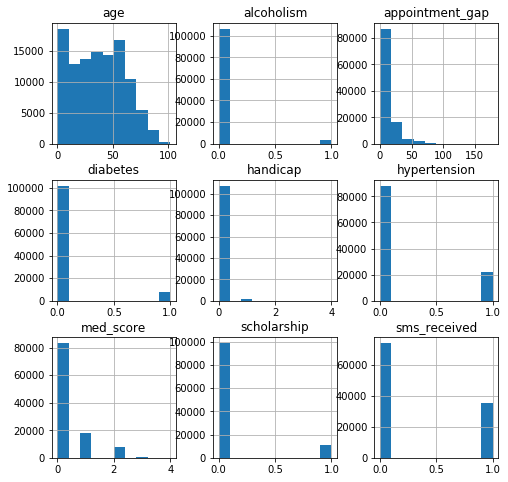

In [19]:
df.hist(figsize = (8,8));

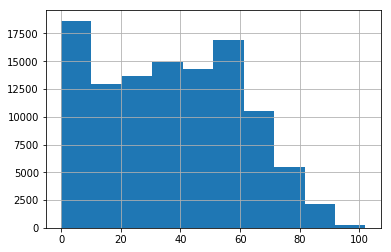

In [20]:
df['age'].hist();

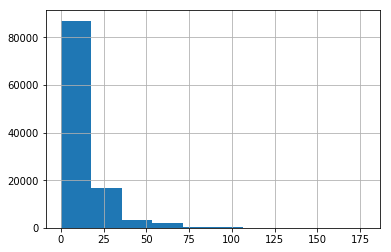

In [21]:
df['appointment_gap'].hist();

>Looks like the vast majority of appointment gaps are 15 days or under.

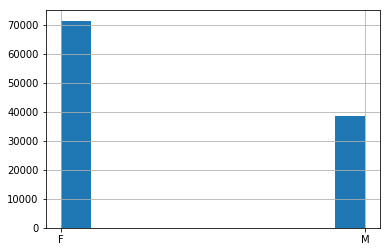

In [22]:
df['gender'].hist();

>Looks like there are almost twice as many female appointments as male appointments.

### Effect of medical factors on probability of missing appointments

>Next I would like to look at the percentage of missed appointments for each unique value for each variable. I will need to create another helper function in order to do this. The function needs to accept a column label and data frame, and create a new data frame with rows for each unique value for that column label and the probability of missing an appointment for that unique value. I will be able to use this function for all of the columns I intend to analyze.

In [23]:
#https://stackoverflow.com/a/24913075

def prob_values(query, data):
    #create new data frame with appropriate columns
    out = pd.DataFrame(columns = [query,'probability'])
    
    #pull every unique value from the query argument
    values = data[query].unique().tolist()
    
    #sort the list for cleanliness
    values.sort()
    
    #calculate probabilities for every unique value
    for x in range(len(values)):
        
        #divide the total number of missed appointments that fit the unique value for this column,
        #by the total number of appointments for the unique value for this column
        prob = len(data.query('{} == "{}" & no_show == "Yes"'.format(query, values[x])))/len(data.query('{} == "{}"'.format(query, values[x])))
        
        #add the result to the output dataframe
        out.loc[x] = [values[x], prob]
        
    return out

>Now let's look at the probabilities for gender, each medical condition, and medical score. 1 means patients with the condition and 0 means without. It is unclear from the original source what the 0-4 handicap status means but I will assume that they are different levels of impairment for the patient.

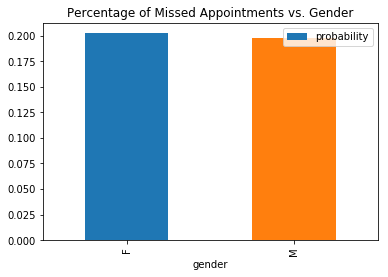

In [31]:
df_gender = prob_values('gender',df)
df_gender.plot(kind = 'bar', x = 'gender', y = 'probability', title = 'Percentage of Missed Appointments vs. Gender');

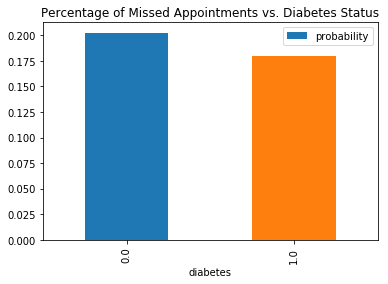

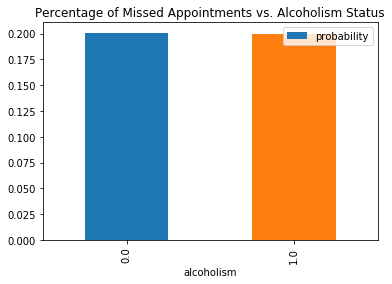

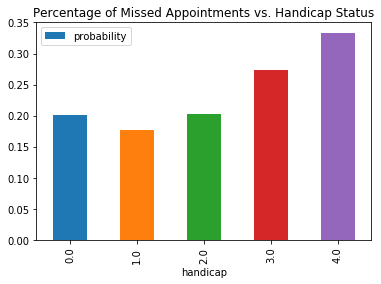

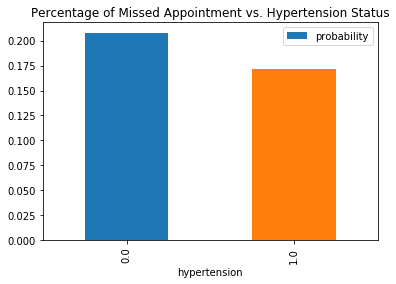

In [25]:
df_diabetes = prob_values('diabetes',df)
df_diabetes.plot(kind = 'bar', x = 'diabetes', y = 'probability', title = 'Percentage of Missed Appointments vs. Diabetes Status');

df_alcoholism = prob_values('alcoholism',df)
df_alcoholism.plot(kind = 'bar', x = 'alcoholism', y = 'probability', title = 'Percentage of Missed Appointments vs. Alcoholism Status');

df_handicap = prob_values('handicap',df)
df_handicap.plot(kind = 'bar', x = 'handicap', y = 'probability', title = 'Percentage of Missed Appointments vs. Handicap Status');

df_hypertension = prob_values('hypertension',df)
df_hypertension.plot(kind = 'bar', x = 'hypertension', y = 'probability', title = 'Percentage of Missed Appointment vs. Hypertension Status');

>We can see from the graphs that there is very little correlation between gender, diabetic status, or alcoholic status and the percentage of missed appointments. However, there appears to be a relatively strong correlation between a higher handicap status and no-show likelihood. The patients with handicap status 4 missed 20% more appointments than those with handicap status 1. Additionally, patients with hypertension were slightly more likely to show up for appointments than those without. It's important to note that the vast majority of patients do not have any of these medical conditions as evidenced by the histograms above.

>Let's now look at the medical score and see if it tells us anything useful about no-show probability.

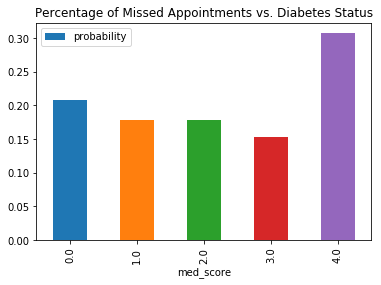

In [26]:
df_med_score = prob_values('med_score',df)
df_med_score.plot(kind = 'bar', x = 'med_score', y = 'probability', title = 'Percentage of Missed Appointments vs. Diabetes Status');

>This plot indicates a slight decrease in no-show probability for higher med_scores except for med_scores of 4. Although, this analysis is quite superficial and is merely inquisitory it would be interesting to do an analysis on combinations of medical conditions, perhaps on a larger sample size.

### Effect of age, appointment gap, scholarship, and sms_reminder on probability of missing appointments

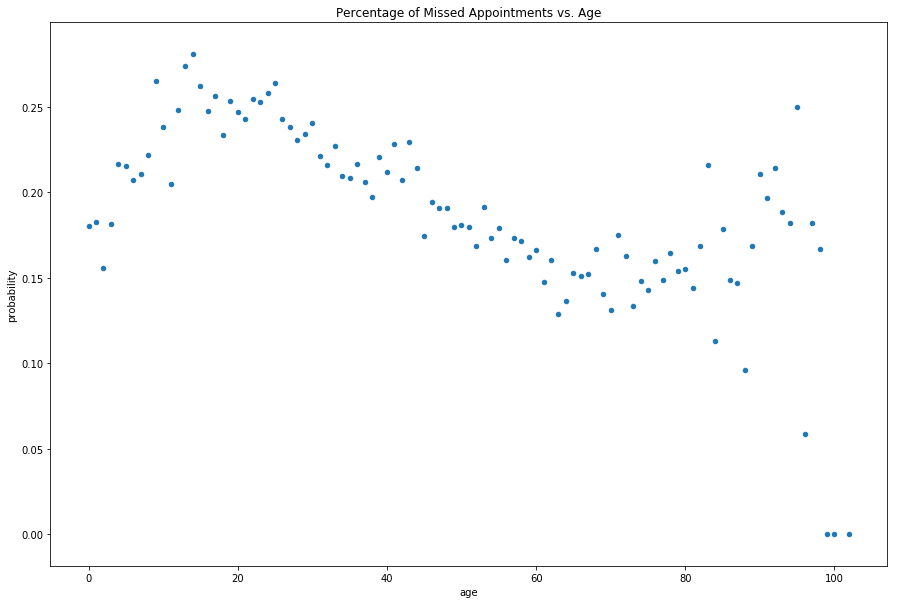

In [27]:
df_age = prob_values('age',df)
df_age.plot(kind = 'scatter', x = 'age', y = 'probability', figsize = (15,10), title = 'Percentage of Missed Appointments vs. Age');

>Now this graph is promising, it shows a definite trend of a decrease in no-show probability as the patient age increases. 

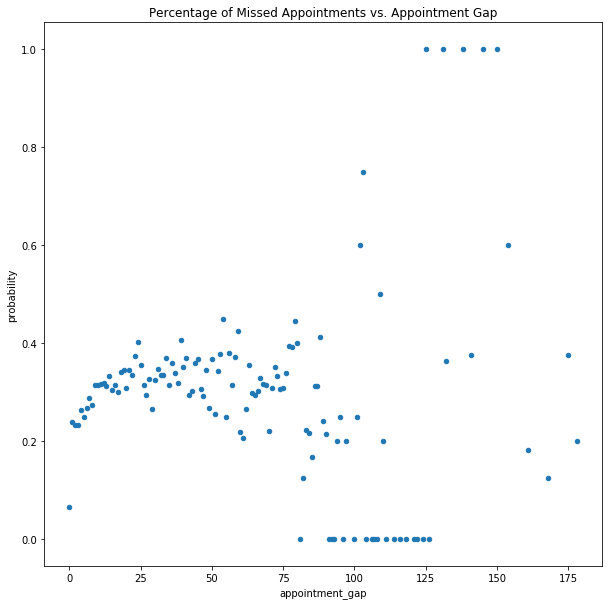

In [28]:
df_app_gap = prob_values('appointment_gap',df)
df_app_gap.plot(kind = 'scatter', x = 'appointment_gap', y = 'probability', title = 'Percentage of Missed Appointments vs. Appointment Gap', figsize = (10,10));

>This correlation is not nearly as strong as the correlation with age. It would appear that the appointment gap is not a strong indicator of no-show probability.

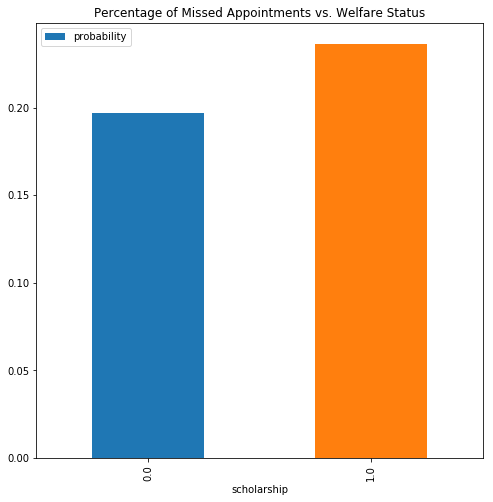

In [29]:
df_scholarship = prob_values('scholarship',df)
df_scholarship.plot(kind = 'bar', x = 'scholarship', y = 'probability', figsize = (8,8), title = 'Percentage of Missed Appointments vs. Welfare Status');

>~5% more patients on welfare no-showed for their appointments than those without.

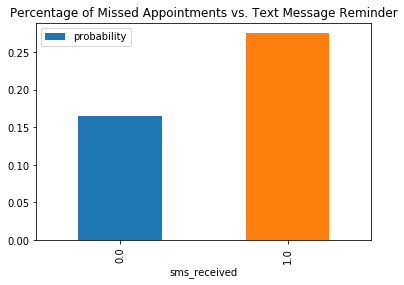

In [30]:
df_sms = prob_values('sms_received',df)
df_sms.plot(kind = 'bar', x = 'sms_received', y = 'probability', title = 'Percentage of Missed Appointments vs. Text Message Reminder');

>Now this is interesting! This shows that over 10% more patients that received a text message reminder showed up for their appointment than those that didn't, regardless of any other factor. Maybe the hospitals should look into sending multiple reminders and stressing the effectiveness of text messages as insurance for their appointments.

<a id='conclusions'></a>
## Conclusions


>What I've shown in this report are some observations between age, handicap status, and text message reminders and the likelihood of showing up for an appointment. It is important to note that more in-depth analysis and a larger, more varied, and more detailed sample would be necessary to conclusively state no-show probability. This is merely an exploratory data analysis, and, while interesting, does not conclusively show anything about a patient's likelihood to show up for an appointment. 